# packages needed to run this file:
- conda install pandas pybedtools matplotlib seaborn numpy tqdm gffutils

In [1]:
%matplotlib inline
import pandas as pd
import pybedtools as bt
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import numpy as np
import math
import pybedtools
import gffutils
from tqdm import tnrange, tqdm_notebook
from collections import OrderedDict, defaultdict
pd.set_option("display.max_rows",500)
gffhead = ['seqname','source','feature','start','end','score','strand','frame','attribute']

# Define constants and annotations

In [2]:
geneset = 'ws257'
# original gff file contains a bunch of other annotations we don't want to use... let's just use wormbase.
original_gff = '/projects/ps-yeolab3/bay001/annotations/c_elegans.PRJNA13758.WS257.annotations.gff3'

wormbase_gff = '/projects/ps-yeolab3/bay001/annotations/c_elegans.PRJNA13758.WS257.annotations.wormbase.gff3'
canonical_geneset = '/projects/ps-yeolab3/bay001/annotations/c_elegans.PRJNA13758.WS257.canonical_geneset.gtf'

extended_geneset = '/projects/ps-yeolab3/bay001/annotations/c_elegans.PRJNA13758.WS257.canonical_geneset.extend_utr.gtf'
db_file = '/projects/ps-yeolab3/bay001/annotations/c_elegans.PRJNA13758.WS257.canonical_geneset.extend_utr.gtf.db'
wormbase_db_file = '/projects/ps-yeolab3/bay001/annotations/c_elegans.PRJNA13758.WS257.annotations.wormbase.gff3.db'

priority = '/projects/ps-yeolab3/bay001/hundley_rnae_20160210/analysis/editor_response_minor_1/priority.txt'
priority_udfirst = '/projects/ps-yeolab3/bay001/hundley_rnae_20160210/analysis/editor_response_minor_1/priority2.txt'

# list of validated differentially expressed genes by qPCR
VALIDATED = ['WBGene00007153','WBGene00000831','WBGene00022644','WBGene00002013','WBGene00009242']

# Specify input directory and files

In [3]:
wd = '/projects/ps-yeolab3/bay001/hundley_rnae_20160210/analysis/editing_calls_v18/{}/'.format(geneset)
# directory where the bam files are. Needed only for exon coverage calculations.
bamdir = '/projects/ps-yeolab3/bay001/hundley_rnae_20160210/analysis/rnae_v6' 
# known edited genes (used to intersect called events with known edited genes)
existing_transcripts = '/projects/ps-yeolab3/bay001/hundley_rnae_20160210/data/other_papers_called_transcripts.tab' 
# adr1 RIP targets (used to intersect edited genes with genes bound by adr1)
adr_common_targets_list = '/projects/ps-yeolab3/bay001/hundley_rnae_20160210/analysis/ADR-1-RIP-targets-sent-to-Yeo-lab-May-2017.txt' 
# list of validated events
validated_events_from_sarah = '/projects/ps-yeolab3/bay001/hundley_rnae_20160210/040517_supplemental_document_1_validated.events.csv' 
# go annotations downloaded from: http://geneontology.org/page/download-annotations
go_association_file = '/projects/ps-yeolab3/bay001/hundley_rnae_20160210/gene_association.wb' 
# deseq2 differential expression results table.
from_deseq2 = '/projects/ps-yeolab3/bay001/hundley_rnae_20160210/analysis/differential_expression/{}/diffexp.tsv'.format(
    geneset
)

# filter settings
min_confidence = 0.99

fwd_bed = os.path.join(
    wd, 'WT.fwd.sorted.rmdup.readfiltered.formatted.varfiltered.snpfiltered.ranked.bed')
rev_bed = os.path.join(
    wd, 'WT.rev.sorted.rmdup.readfiltered.formatted.varfiltered.snpfiltered.ranked.bed')

fwd_adr = os.path.join(
    wd, 'adr2ko.fwd.sorted.rmdup.readfiltered.formatted.varfiltered.snpfiltered.ranked.bed')
rev_adr = os.path.join(
    wd, 'adr2ko.rev.sorted.rmdup.readfiltered.formatted.varfiltered.snpfiltered.ranked.bed')

editing_calls_dir = '/projects/ps-yeolab3/bay001/hundley_rnae_20160210/analysis/editing_test_against_aiden/'

# Specify output directory and files

In [4]:
output_directory = '/projects/ps-yeolab3/bay001/hundley_rnae_20160210/analysis/editor_response_minor_1/{}/'.format(geneset)
known_snp_bed3file = os.path.join(output_directory,'known_snps.bed3')
all_output_regions_piechart = os.path.join(output_directory,'all_pie.svg')
all_output_regions_annotations = os.path.join(output_directory,'annotations.txt')
all_output_regions_wbgene_annotations = os.path.join(output_directory,'annotations_wbgene.txt')
chemotaxis_locomotion_goterms = os.path.join(output_directory,'annotations_locomotion_and_chemotaxis.txt')
validation_comparisons = os.path.join(output_directory,'validation_comparisons.txt')
existing_transcripts_wbgene = os.path.join(output_directory, 'other_papers_called_transcripts.with_names.{}.tab'.format(geneset)) # known edited genes with wbgene names

supplemental_doc1_edited_genes = os.path.join(output_directory,'supplemental_doc_1.txt')
supplemental_doc1_sanger = os.path.join(output_directory,'supplemental_doc_1.sanger.txt')
supplemental_doc1_genes = os.path.join(output_directory,'supplemental_doc_1.genes.txt')
supplemental_doc1_novel = os.path.join(output_directory,'supplemental_doc_1.novel.txt')
supplemental_doc1_locomotion = os.path.join(output_directory,'supplemental_doc_1.locomotion.txt')

supplemental_doc2_upregulated_genes = os.path.join(output_directory,'supplemental_doc_2_upregulated_genes.txt')
supplemental_doc2_downregulated_genes = os.path.join(output_directory,'supplemental_doc_2_downregulated_genes.txt')

# Create annotation file for known SNPs

In [5]:
# let's also parse this file while we have it to get the 'known SNP and point mutations'
def make_snp_file(original_gff, known_snp_bed3file):
    """
    Use the original GFF file to create a 'known snps' BED file.
    Conservatively checking both strands, so we only need a BED3 file.
    """
    original_gff_df = pd.read_table(original_gff,names=gffhead)
    snp = original_gff_df[
        (original_gff_df['feature']=='SNP') | (original_gff_df['feature']=='point_mutation')
    ]
    snp['seqname_chr_formatted'] = 'chr' + snp['seqname']
    snp['start_formatted'] = snp['start'].astype(int) - 1
    snp['end_formatted'] = snp['end'].astype(int)
    snp = snp[['seqname_chr_formatted','start_formatted','end_formatted']]
    snp.drop_duplicates(inplace=True)
    print('number of snps and single point mutations: {}'.format(snp.shape[0]))
    snp.to_csv(known_snp_bed3file, sep='\t', index=False, header=False)

def make_wormbase_and_format(original_gff, editing_annotation_file):
    """
    pulls just the wormbase annotations
    need to reformat the chromosome names from 'I, II' to 'chrI and chrII etc.'
    """
    original_gff_df = pd.read_table(original_gff,names=gffhead, comment='#')
    print("size of the original gff: {}".format(original_gff_df.shape[0]))  # wow... lots of entries
    wormbase = original_gff_df[original_gff_df['source']=='WormBase']
    wormbase['seqname'] = 'chr'+wormbase['seqname'].replace('MtDNA','M')
    wormbase[['start','end']] = wormbase[['start','end']].astype(int)  # change positions to INT from FLOAT
    wormbase.sort_values(by=['seqname','start','end'], inplace=True)
    wormbase.to_csv(editing_annotation_file, sep='\t', index=None, header=None)

    print("size of the wormbase gff: {}".format(wormbase.shape[0]))  # better...
    
if not os.path.exists(known_snp_bed3file):
    make_snp_file(original_gff, known_snp_bed3file)
if not os.path.exists(wormbase_gff):
    make_wormbase_and_format(original_gff, wormbase_gff)
original_gff

'/projects/ps-yeolab3/bay001/annotations/c_elegans.PRJNA13758.WS257.annotations.gff3'

# Run the editing pipeline
- Use the 'known_snps' bed3 file

# Run DESeq2 for differential expression
- Use the WS257 "canonical geneset" annotations

# Analyses in this notebook:
- filter confidence, 
- remove 'false positives' from KO
- 'forward' and 'reverse' are designated based on editing site strand 
- annotation using Annotator: https://github.com/byee4/annotator
- intersection of editing sites and differential expression
- intersection of editing sites and known edited genes from other publications
- intersection of editing sites and experimentally validated editing sites (sanger sequencing)
- intersection of editing sites and GO terms

# Concatenate and assign false positives from ADR KO to WT

In [6]:
# format the bedfile
out_filtered_bed = os.path.join(output_directory,'filtered.bed')

fwd = pd.read_table(fwd_bed, names=['chrom','start','end','name','score','strand'])
rev = pd.read_table(rev_bed, names=['chrom','start','end','name','score','strand'])

adrf = pd.read_table(fwd_adr, names=['chrom','start','end','name','score','strand'])
adrr = pd.read_table(rev_adr, names=['chrom','start','end','name','score','strand'])

bed = pd.concat([fwd, rev])
bed = bed[bed['score']>min_confidence]
bed.shape

bed_a = pd.concat([adrf, adrr])
bed_a = bed_a[bed_a['score']>min_confidence]

keys = ['chrom', 'start', 'end', 'strand']
i1 = bed.set_index(keys).index
i2 = bed_a.set_index(keys).index
filtered_bed = bed

filtered_bed = bed[~i1.isin(i2)]
filtered_bed.to_csv(out_filtered_bed, sep='\t', index=False, header=False)
print("Number of editing sites called: {}".format(filtered_bed.shape[0]))
filtered_bed.head()

Number of editing sites called: 7362


,chrom,start,end,name,score,strand
57,chrI,454105,454106,5|A>G|0.8,1.000000,+
58,chrI,454110,454111,5|A>G|0.4,0.999408,+
60,chrI,454112,454113,5|A>G|0.6,0.999996,+
61,chrI,454117,454118,5|A>G|0.6,0.999996,+
63,chrI,454329,454330,5|A>G|0.4,0.999408,+


# Annotation of WT
- build a gtf file that contains annotations for not only the annotated regions, but also the up/downstream regions as well.
- For genes, look for 5'UTR, 3'UTR features, and create new GTF entries for each that are 2000bp up/downstream
- Also, look for start/stop codon features, there are some genes with unannotated/missing/nonexistant UTR regions
- For noncoding genes/transcripts, create new GTF entries 2000bp up/downstream each found transcript.
- Pay attention to the coordinates such that no new feature has negative start/stop positions
- build an SQLITE database using this GTF file using build_db()

In [7]:
import copy
# This section appends to genes a 2000bp window extending each featuretype by 2000bp
o = open(extended_geneset, 'w')
with open(canonical_geneset, 'r') as f:
    for line in f:
        ### If we have a comment, leave it alone and write it.
        if line.startswith('#'):
            o.write(line)
        else:
            ### write the original annotation.
            o.write(line)
            newline = copy.deepcopy(line).split('\t')
            ### If we find an annotated 5' UTR, create an 'upstream' region 2000bp upstream of that.
            if (newline[2] == 'five_prime_utr') or (newline[2] == 'start_codon'):
                name = 'upstream_gene'
                if newline[6] == '+':
                    newstart = int(newline[3]) - 2000
                    newend = int(newline[3]) - 1
                elif newline[6] == '-':
                    newstart = int(newline[4]) + 1
                    newend = int(newline[4]) + 2000
                o.write('{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\n'.format(
                    newline[0],newline[1],name,newstart,newend,newline[5],newline[6],newline[7],newline[8]
                ))
                name = ''
                newstart = 0
                newend = 0
            ### If we find an annotated 3' UTR, create a 'downstream' region 2000bp long.
            elif (newline[2] == 'three_prime_utr') or (newline[2] == 'stop_codon'):
                name = 'downstream_gene'
                if newline[6] == '+':
                    newstart = int(newline[4]) + 1
                    newend = int(newline[4]) + 2000
                elif newline[6] == '-':
                    newstart = int(newline[3]) - 2000
                    newend = int(newline[3]) - 1
                o.write('{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\n'.format(
                    newline[0],newline[1],name,newstart,newend,newline[5],newline[6],newline[7],newline[8]
                ))
                name = ''
                newstart = 0
                newend = 0
            ### If we find an annotated non-protein-coding gene/transcript, 
            elif newline[2] == 'gene' and 'protein_coding' not in newline[8]:
                name = 'upstream_noncoding_gene'
                if newline[6] == '+':
                    newstart = str(max(int(newline[3]) - 2000, 1))
                    newend = int(newline[3]) - 1
                elif newline[6] == '-':
                    newstart = int(newline[4]) + 1
                    newend = str(int(newline[4]) + 2000)
                o.write('{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\n'.format(
                    newline[0],newline[1],name,newstart,newend,newline[5],newline[6],newline[7],newline[8]
                ))
                name = ''
                newstart = 0
                newend = 0
                name = 'downstream_noncoding_gene'
                if newline[6] == '+':
                    newstart = int(newline[4]) - 1
                    newend = str(int(newline[4]) + 2000)
                elif newline[6] == '-':
                    newstart = str(max(int(newline[3]) - 2000, 1))
                    newend = int(newline[3]) - 1
                o.write('{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\n'.format(
                    newline[0],newline[1],name,newstart,newend,newline[5],newline[6],newline[7],newline[8]
                ))
                name = ''
                newstart = 0
                newend = 0
            elif newline[2] == 'transcript' and 'protein_coding' not in newline[8]:
                name = 'upstream_noncoding_transcript'
                if newline[6] == '+':
                    newstart = str(max(int(newline[3]) - 2000, 1))
                    newend = int(newline[3]) - 1
                elif newline[6] == '-':
                    newstart = int(newline[4]) + 1
                    newend = str(int(newline[4]) + 2000)
                o.write('{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\n'.format(
                    newline[0],newline[1],name,newstart,newend,newline[5],newline[6],newline[7],newline[8]
                ))
                name = ''
                newstart = 0
                newend = 0
                name = 'downstream_noncoding_transcript'
                if newline[6] == '+':
                    newstart = int(newline[4]) + 1
                    newend = str(int(newline[4]) + 2000)
                elif newline[6] == '-':
                    newstart = str(max(int(newline[3]) - 2000, 1))
                    newend = int(newline[3]) - 1
                o.write('{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\n'.format(
                    newline[0],newline[1],name,newstart,newend,newline[5],newline[6],newline[7],newline[8]
                ))
                name = ''
                newstart = 0
                newend = 0
            else:
                pass
o.close()

In [8]:
# build a databse using this new set of annotations.
import gffutils

def build_db(annotation_file, db_file, force=True, disable_infer_genes=True, disable_infer_transcripts=True):
    db = gffutils.create_db(
        annotation_file, dbfn=db_file, force=force, # change to True if we need to create a new db
        keep_order=True, merge_strategy='merge', sort_attribute_values=True,
        disable_infer_genes=disable_infer_genes,
        disable_infer_transcripts=disable_infer_transcripts
    )
build_db(extended_geneset, db_file, disable_infer_genes=True, disable_infer_transcripts=True)

In [9]:
# Build a priority
priority_list = ['protein_coding,three_prime_utr',
'protein_coding,five_prime_utr',
'protein_coding,CDS',
'protein_coding,start_codon',
'protein_coding,stop_codon',
'protein_coding,exon',
'protein_coding,intron',
'protein_coding,transcript',
'non_coding,exon',
'non_coding,intron',
'protein_coding,downstream_gene',
'protein_coding,upstream_gene',
'non_coding,downstream_noncoding_transcript',
'non_coding,upstream_noncoding_transcript']

o = open(priority, 'w')
for p in priority_list:
    o.write('{}\n'.format(p))
o.close()
!head /projects/ps-yeolab3/bay001/hundley_rnae_20160210/analysis/editor_response_minor_1/priority.txt

protein_coding,three_prime_utr
protein_coding,five_prime_utr
protein_coding,CDS
protein_coding,start_codon
protein_coding,stop_codon
protein_coding,exon
protein_coding,intron
protein_coding,transcript
non_coding,exon
non_coding,intron


# Run annotation script

In [10]:
# run annotation script
species = 'ce11'

cmd = 'python /home/bay001/projects/codebase/annotator/annotator/annotate.py '
cmd = cmd + '--input {} '.format(out_filtered_bed)
cmd = cmd + '--output {} '.format(out_filtered_bed + '.annotated')
cmd = cmd + '--gtfdb {} '.format(db_file)
cmd = cmd + '--transcript-priority-file {} '.format(priority)
cmd = cmd + '--gene-priority-file {} '.format(priority)
cmd = cmd + '--append_chr '
cmd = cmd + '--species {} '.format(species)
! $cmd

Adding all CDS boundaries: 100%|##################| 7/7 [02:45<00:00, 22.08s/it]

# Plot pie chart of annotated sites in which we prioritize introns over up/downstream genic regions 

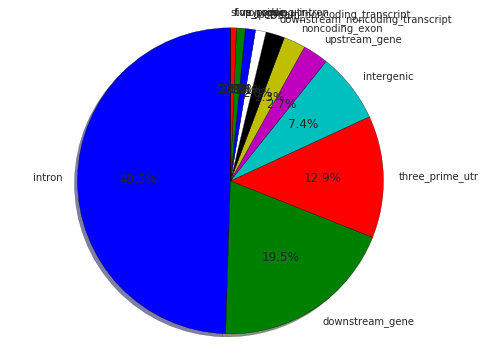

In [11]:
import matplotlib.pyplot as plt

def get_region(row):
    try:
        if 'INTERGENIC' in row['priority']:
            return 'intergenic'
        else:
            return row['priority'].split(':')[4]
    except Exception as e:
        print(e, row['priority'])
        
        
annotated = pd.read_table(
    out_filtered_bed + '.annotated', 
    names=['chrom','start','stop','name','score','strand','priority','annotated']
)
annotated['region'] = annotated.apply(get_region, axis=1)
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = list(annotated['region'].value_counts().keys())
sizes = list(annotated['region'].value_counts())

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [12]:
annotated[annotated['region']=='exon'] # we shouldn't have 'just protein coding exon', 3/5UTR/CDS should all be prioritized first.

,chrom,start,stop,name,score,strand,priority,annotated,region


# Plot pie chart except we now prioritize upstream and downstream genes ahead of introns
- just call this annotated1 for now, we don't know which priority we'll ultimately roll with
- let's use the first priority and discard this one... the few instances we checked individually look more like introns than they do up/downstream genes. 

Adding all CDS boundaries: 100%|##################| 7/7 [02:45<00:00, 22.10s/it]

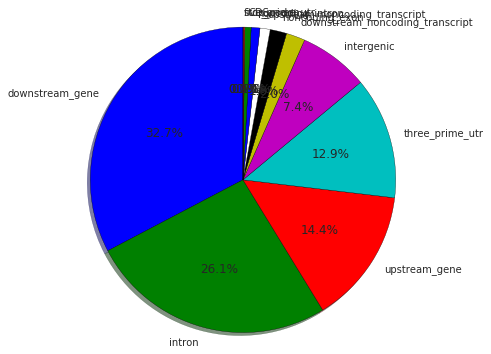

In [13]:
# Build a priority
priority_list = [
    'protein_coding,three_prime_utr',
    'protein_coding,downstream_gene', # this above introns
    'protein_coding,five_prime_utr', 
    'protein_coding,upstream_gene', # this above introns
    'protein_coding,CDS',
    'protein_coding,start_codon',
    'protein_coding,stop_codon',
    'protein_coding,exon',
    'protein_coding,intron',
    'protein_coding,transcript',
    'non_coding,exon',
    'non_coding,intron',
    'non_coding,downstream_noncoding_transcript',
    'non_coding,upstream_noncoding_transcript'
]

o = open(priority_udfirst, 'w')
for p in priority_list:
    o.write('{}\n'.format(p))
o.close()

# run annotation script
species = 'ce11'

cmd = 'python /home/bay001/projects/codebase/annotator/annotator/annotate.py '
cmd = cmd + '--input {} '.format(out_filtered_bed)
cmd = cmd + '--output {} '.format(out_filtered_bed + '.annotated_ud')
cmd = cmd + '--gtfdb {} '.format(db_file)
cmd = cmd + '--transcript-priority-file {} '.format(priority_udfirst)
cmd = cmd + '--gene-priority-file {} '.format(priority_udfirst)
cmd = cmd + '--append_chr '
cmd = cmd + '--species {} '.format(species)
! $cmd
        
annotated1 = pd.read_table(
    out_filtered_bed + '.annotated_ud', 
    names=['chrom','start','stop','name','score','strand','priority','annotated']
)
annotated1['region'] = annotated1.apply(get_region, axis=1)
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = list(annotated1['region'].value_counts().keys())
sizes = list(annotated1['region'].value_counts())

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()


# Print the false positives and look to see if they make sense...

In [14]:
bed_a

,chrom,start,end,name,score,strand
882,chrI,6560744,6560745,16|A>G|0.125,0.990370,+
1406,chrI,9972128,9972129,6|A>G|0.333333333,0.999020,+
2273,chrII,3817204,3817205,69|A>G|0.086956522,0.999936,+
2780,chrII,7123750,7123751,13|A>G|0.153846154,0.993825,+
2782,chrII,7123997,7123998,6|A>G|0.5,0.999990,+
2926,chrII,8059074,8059075,10|A>G|0.3,0.999920,+
3414,chrII,11216019,11216020,5|A>G|0.6,0.999996,+
5821,chrIII,12944195,12944196,7|A>G|0.285714286,0.998540,+
6515,chrIV,5716593,5716594,6|A>G|0.333333333,0.999020,+
6811,chrIV,7595253,7595254,5|A>G|0.6,0.999996,+


# Add wbgenes (parse my annotation structure to more easily read genic info)

In [15]:
def get_wbgene(row):
    try:
        if 'INTERGENIC' in row['priority']:
            return 'intergenic'
        else:
            return row['priority'].split(':')[5]
    except Exception as e:
        print(e, row['priority'])

def get_coverage(row):
    return row['name'].split('|')[0]

def get_edit(row):
    return row['name'].split('|')[1]

def get_edit_fraction(row):
    return row['name'].split('|')[2]

def get_gene_name(row):
    if row['wbgene'] == 'intergenic':
        return 'intergenic'
    else:
        return 
    
annotated['wbgene'] = annotated.apply(get_wbgene, axis=1)
annotated['edit_fraction'] = annotated.apply(get_edit_fraction, axis=1)
annotated['coverage'] = annotated.apply(get_coverage, axis=1)
annotated['edit'] = annotated.apply(get_edit, axis=1)
annotated.head()

,chrom,start,stop,name,score,strand,priority,annotated,region,wbgene,edit_fraction,coverage,edit
0,chrI,454105,454106,5|A>G|0.8,1.000000,+,C07F11.1:451461:455355:+:intron:WBGene00006593...,C07F11.1:443998:461605:+:transcript:WBGene0000...,intron,WBGene00006593,0.8,5,A>G
1,chrI,454110,454111,5|A>G|0.4,0.999408,+,C07F11.1:451461:455355:+:intron:WBGene00006593...,C07F11.1:443998:461605:+:transcript:WBGene0000...,intron,WBGene00006593,0.4,5,A>G
2,chrI,454112,454113,5|A>G|0.6,0.999996,+,C07F11.1:451461:455355:+:intron:WBGene00006593...,C07F11.1:443998:461605:+:transcript:WBGene0000...,intron,WBGene00006593,0.6,5,A>G
3,chrI,454117,454118,5|A>G|0.6,0.999996,+,C07F11.1:451461:455355:+:intron:WBGene00006593...,C07F11.1:443998:461605:+:transcript:WBGene0000...,intron,WBGene00006593,0.6,5,A>G
4,chrI,454329,454330,5|A>G|0.4,0.999408,+,C07F11.1:451461:455355:+:intron:WBGene00006593...,C07F11.1:443998:461605:+:transcript:WBGene0000...,intron,WBGene00006593,0.4,5,A>G


In [16]:
# check a random annotation to make sure this makes sense.
annotated.ix[1]['priority']

'C07F11.1:451461:455355:+:intron:WBGene00006593:C07F11.1:protein_coding:feature_contains_query'

# Write annotated editing sites to csv as intermediate

In [17]:
annotated.to_csv(
    all_output_regions_wbgene_annotations,
    sep='\t',
    index=None,
)

# Using an existing list of edited sites, check to see how many we've found/are novel
- Give wbgene names to other discovered transcripts
- transform existing editing sites (from other papers) into their wbgene name, to compare to our calls.

In [18]:
genes_from_sarah = pd.read_table(
    existing_transcripts,
    names=['transcript1','name1','transcript2','name2','transcript3','name3']
)
genes_from_sarah.fillna('.',inplace=True)
genes_from_sarah.head()

,transcript1,name1,transcript2,name2,transcript3,name3
0,3R5.1,.,3R5.1,.,2L52.1,.
1,3R5.1,.,3R5.1,.,2L52.1,.
2,3R5.1,.,B0035.14,.,2L52.1,.
3,3R5.1,.,B0041.5,.,2L52.1,.
4,3R5.1,.,B0281.1,.,2RSSE.1,.


# Convert transcript names to their wbgene IDs
- This makes things easier to go back/forth between old/new annotations
- The canonical geneset gtf file does not contain many of the older names that are listed in the 'previously found' list. We need to use a database generated from the gff which contains all transcript IDs. 

In [19]:
## USE A DIFFERENT "GFF" DB FILE BECAUSE it still has the older annotations 
## (ie. 3R5.1 instead of 3R5.1a, 3R5.1b)

if not os.path.exists(wormbase_db_file):
    build_db(wormbase_gff, wormbase_db_file)
    
DATABASE = gffutils.FeatureDB(
    wormbase_db_file
)

In [20]:
# helper functions to build the gene-to-id dictionaries/hash

def gene_id_to_name(db, attribute='Name'):
    '''
    takes a gene id and returns the first name associated (one-to-one)
    '''
    # db = gffutils.FeatureDB(db)
    genes = db.features_of_type('gene')
    gene_name_dict = {}
    for gene in genes:
        gene_id = gene.attributes['Name'][0] if type(gene.attributes['Name']) == list else gene.attributes['Name']
        try:
            gene_name_dict[gene_id] = gene.attributes['Alias'][0]
        except KeyError:
            print("Warning. Key not found for {}".format(gene))
    return gene_name_dict

def gene_name_to_id(db, attribute='Name'):
    '''
    takes the name and returns a list of associated IDs (one-to-many)
    '''
    # db = gffutils.FeatureDB(db)
    genes = db.features_of_type('gene')
    gene_name_dict = defaultdict(list)
    for gene in genes:
        try:
            gene_name_dict[gene.attributes['sequence_name'][0]].append(gene.attributes['Name'][0])
        except KeyError as e:
            print(e)
            return 1
            # print("Warning. Key not found for {}".format(gene))
    return gene_name_dict

In [21]:
id2name_dict = gene_id_to_name(DATABASE)
name2id_dict = gene_name_to_id(DATABASE)

In [22]:
# Helper functions to use to apply translations across all rows/columns

def name2id(row, col='transcript1'):
    if row[col] == '.':
        return '.'
    else:
        ret = name2id_dict[row[col]]
    if len(ret) == 0:
        return '.'
    else:
        return ret[0]
    
def add_name(row, col='wbgene1'):
    if row[col] == '.' or row[col] == 'intergenic':
        return '.'
    else:
        ret = id2name_dict[row[col]]
    if len(ret) == 0:
        return '.'
    else:
        return ret

In [23]:
# may as well convert the wbgene ids in our annotated file to names here:
annotated['gene'] = annotated.apply(add_name, axis=1, args=['wbgene'])
annotated.head()

,chrom,start,stop,name,score,strand,priority,annotated,region,wbgene,edit_fraction,coverage,edit,gene
0,chrI,454105,454106,5|A>G|0.8,1.000000,+,C07F11.1:451461:455355:+:intron:WBGene00006593...,C07F11.1:443998:461605:+:transcript:WBGene0000...,intron,WBGene00006593,0.8,5,A>G,tol-1
1,chrI,454110,454111,5|A>G|0.4,0.999408,+,C07F11.1:451461:455355:+:intron:WBGene00006593...,C07F11.1:443998:461605:+:transcript:WBGene0000...,intron,WBGene00006593,0.4,5,A>G,tol-1
2,chrI,454112,454113,5|A>G|0.6,0.999996,+,C07F11.1:451461:455355:+:intron:WBGene00006593...,C07F11.1:443998:461605:+:transcript:WBGene0000...,intron,WBGene00006593,0.6,5,A>G,tol-1
3,chrI,454117,454118,5|A>G|0.6,0.999996,+,C07F11.1:451461:455355:+:intron:WBGene00006593...,C07F11.1:443998:461605:+:transcript:WBGene0000...,intron,WBGene00006593,0.6,5,A>G,tol-1
4,chrI,454329,454330,5|A>G|0.4,0.999408,+,C07F11.1:451461:455355:+:intron:WBGene00006593...,C07F11.1:443998:461605:+:transcript:WBGene0000...,intron,WBGene00006593,0.4,5,A>G,tol-1


In [24]:
# For each transcript ID given, annotate with the proper wbgene ID and its proper name

progress = tnrange(6)
genes_from_sarah['wbgene1'] = genes_from_sarah.apply(name2id, axis=1, args=['transcript1'])
progress.update(1)
genes_from_sarah['wbgene2'] = genes_from_sarah.apply(name2id, axis=1, args=['transcript2'])
progress.update(1)
genes_from_sarah['wbgene3'] = genes_from_sarah.apply(name2id, axis=1, args=['transcript3'])
progress.update(1)
genes_from_sarah['name1'] = genes_from_sarah.apply(add_name, axis=1, args=['wbgene1'])
progress.update(1)
genes_from_sarah['name2'] = genes_from_sarah.apply(add_name, axis=1, args=['wbgene2'])
progress.update(1)
genes_from_sarah['name3'] = genes_from_sarah.apply(add_name, axis=1, args=['wbgene3'])
progress.update(1)
genes_from_sarah.head()

Widget Javascript not detected.  It may not be installed or enabled properly.


,transcript1,name1,transcript2,name2,transcript3,name3,wbgene1,wbgene2,wbgene3
0,3R5.1,pot-3,3R5.1,pot-3,2L52.1,2L52.1,WBGene00007065,WBGene00007065,WBGene00007063
1,3R5.1,pot-3,3R5.1,pot-3,2L52.1,2L52.1,WBGene00007065,WBGene00007065,WBGene00007063
2,3R5.1,pot-3,B0035.14,dnj-1,2L52.1,2L52.1,WBGene00007065,WBGene00001019,WBGene00007063
3,3R5.1,pot-3,B0041.5,B0041.5,2L52.1,2L52.1,WBGene00007065,WBGene00015009,WBGene00007063
4,3R5.1,pot-3,B0281.1,B0281.1,2RSSE.1,2RSSE.1,WBGene00007065,WBGene00015108,WBGene00007064


# Get list of already discovered edited genes and compare against ours
- get unique set of gene names known to be edited from previous manuscripts
- print number of edited genes

In [25]:
g1 = list(set(genes_from_sarah['wbgene1'])) # wbgenes edited from list 1
g2 = list(set(genes_from_sarah['wbgene2'])) # wbgenes edited from list 2
g3 = list(set(genes_from_sarah['wbgene3'])) # wbgenes edited from list 3

g_all = []
g_all.append(g1)
g_all.append(g2)
g_all.append(g3)
g = [item for sublist in g_all for item in sublist]
g = set(g)
print("total number of known edited genes: {}".format(len(g)))

total number of known edited genes: 8904


(7362, 14)
(6819, 14)


<matplotlib_venn._common.VennDiagram instance at 0x2b616d1da128>

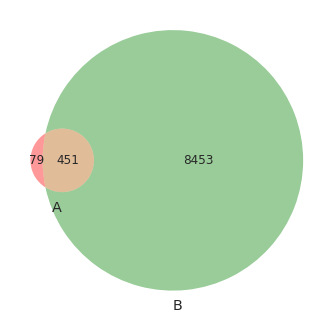

In [26]:

all_annotations_no_intergenic = annotated[annotated['wbgene']!='intergenic'] 
our_g = set(all_annotations_no_intergenic['wbgene']) # full set of genes we've found to be edited (that aren't intergenic)

print(annotated.shape)
print(all_annotations_no_intergenic.shape)
from matplotlib_venn import venn2, venn3
venn2([our_g,g])

In [27]:
with open(supplemental_doc1_genes, 'w') as f:
    f.write("Genes Identified as Edited\n")
    f.write("Wormbase ID\tGene Name\n")
    for gene in our_g:
        f.write('{}\t{}\n'.format(gene,id2name_dict[gene]))
with open(supplemental_doc1_novel, 'w') as f:
    f.write("Novel Genes Identified as Edited\n")
    f.write("Wormbase ID\tGene Name\n")
    for gene in (our_g - g):
        f.write('{}\t{}\n'.format(gene,id2name_dict[gene]))

In [28]:
genes_from_sarah[
    ['transcript1','wbgene1','name1','transcript2','wbgene2','name2','transcript3','wbgene3','name3']
].to_csv(
    existing_transcripts_wbgene,
    sep='\t',
    index=None,
)

# Check to see how many genes were edited

In [29]:
pd.options.display.max_rows = 999
all_annotations_no_intergenic = annotated[annotated['wbgene']!='intergenic']
all_annotations_no_intergenic['wbgene'].value_counts().head() # these genes have the most editing sites

WBGene00016458    241
WBGene00001895    139
WBGene00003153    134
WBGene00004267    117
WBGene00000135    114
Name: wbgene, dtype: int64

In [30]:
print("Number of edited genes: {}".format(len(set(all_annotations_no_intergenic['wbgene']))))

Number of edited genes: 530


In [31]:
# check to see that we've assigned all genic regions. Some may be missed due to inexact matching of IDs in database
all_annotations_no_intergenic[all_annotations_no_intergenic['gene']=='']

,chrom,start,stop,name,score,strand,priority,annotated,region,wbgene,edit_fraction,coverage,edit,gene


# Check against validated sanger editing

In [32]:
# this was the original validation table - we now need to compare the current (0.0.3 pipeline) set with the original (0.0.2) results. 
validated_sites = pd.read_table(
    validated_events_from_sarah,
    sep='\t'
)
validated_sites.head()

,Gene,Chromosome,Editing site position,% edited (RNA seq),Identified in Sanger Sequencing,Predicted by RNA-Seq Pipeline
0,crtc-1,chrI,2033866,NaN,Yes,No
1,crtc-1,chrI,2033878,72.0,Yes,Yes
2,crtc-1,chrI,2033879,10.0,Yes,Yes
3,crtc-1,chrI,2033881,12.0,Yes,Yes
4,crtc-1,chrI,2033888,38.0,Yes,Yes


# Append current annotations to validated dataframe and compare
- should be mostly identical
- differences should come only from changes in pipeline filters

In [33]:
all_annotations_edit_frac = annotated[['chrom','stop','edit_fraction']]
all_annotations_edit_frac.columns = ['Chromosome', 'Editing site position', '0.0.3 % edited (RNA seq)']
validated_df = pd.merge(
    all_annotations_edit_frac, 
    validated_sites, 
    how='right', 
    # on=['Chromosome','Editing site position']
    left_on=['Chromosome', 'Editing site position'], 
    right_on=['Chromosome','Editing site position']
)
validated_df.to_csv(validation_comparisons,sep='\t', index=None)
validated_df.head()

,Chromosome,Editing site position,0.0.3 % edited (RNA seq),Gene,% edited (RNA seq),Identified in Sanger Sequencing,Predicted by RNA-Seq Pipeline
0,chrI,2033878.0,0.727272727,crtc-1,72.0,Yes,Yes
1,chrI,2033879.0,0.106060606,crtc-1,10.0,Yes,Yes
2,chrI,2033881.0,0.123076923,crtc-1,12.0,Yes,Yes
3,chrI,2033888.0,0.383333333,crtc-1,38.0,Yes,Yes
4,chrI,2033911.0,0.133333333,crtc-1,13.0,Yes,Yes


# Compare editing sites discovered by validation (Sanger) that were not picked up by our pipeline

In [34]:
vdf = validated_df.fillna('NONE')
print("Number of sites not captured by pipeline but discovered to be edited via sanger: {}".format(vdf[
    (vdf['Identified in Sanger Sequencing']=='Yes') &
    (vdf['0.0.3 % edited (RNA seq)']=='NONE')
].shape[0]))
print("Number of sites captured by pipeline AND discovered to be edited via sanger: {}".format(vdf[
    (vdf['Identified in Sanger Sequencing']=='Yes') &
    (vdf['0.0.3 % edited (RNA seq)']!='NONE')
].shape[0]))

Number of sites not captured by pipeline but discovered to be edited via sanger: 87
Number of sites captured by pipeline AND discovered to be edited via sanger: 86


In [35]:
# Number of sites captured by the pipeline against Sanger validations
validated_df.dropna(subset=['0.0.3 % edited (RNA seq)'])['Identified in Sanger Sequencing'].value_counts()
validated_df.head()

,Chromosome,Editing site position,0.0.3 % edited (RNA seq),Gene,% edited (RNA seq),Identified in Sanger Sequencing,Predicted by RNA-Seq Pipeline
0,chrI,2033878.0,0.727272727,crtc-1,72.0,Yes,Yes
1,chrI,2033879.0,0.106060606,crtc-1,10.0,Yes,Yes
2,chrI,2033881.0,0.123076923,crtc-1,12.0,Yes,Yes
3,chrI,2033888.0,0.383333333,crtc-1,38.0,Yes,Yes
4,chrI,2033911.0,0.133333333,crtc-1,13.0,Yes,Yes


In [36]:
verification_table = validated_df[
    ['Gene','Chromosome','Editing site position','0.0.3 % edited (RNA seq)',
     'Identified in Sanger Sequencing','Predicted by RNA-Seq Pipeline'
    ]
]
verification_table['Editing site position'] = verification_table['Editing site position'].astype(int)
verification_table.columns = [
    'Gene','Chromosome','Editing site position','0.0.3 % edited (RNA seq)','Identified in Sanger Sequencing','Predicted by RNA-Seq pipeline'
]
verification_table.to_csv(supplemental_doc1_sanger, sep='\t', index=False)

/home/bay001/anaconda2/envs/brian/lib/python2.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


# Check differential expression output
- Not using padj... but this is okay since we're validating our genes of interest anyway.

In [37]:
deseq2_df = pd.read_table(from_deseq2)
deseq2_df.sort_values(by='padj',inplace=True)
l2fc_threshold = 1

In [38]:
print(
    "Number of upregulated genes (with respect to WT): {}".format(
        deseq2_df[(deseq2_df['log2FoldChange']>=l2fc_threshold)].shape[0]
    )
)#  & (deseq2_df['padj']<0.05)].shape
print(
    "Number of downregulated genes (with respect to WT): {}".format(
        deseq2_df[(deseq2_df['log2FoldChange']<=-l2fc_threshold)].shape[0]
    )
)#  & (deseq2_df['padj']<0.05)].shape

Number of upregulated genes (with respect to WT): 76
Number of downregulated genes (with respect to WT): 93


# Check against qPCR Differential Expression validated results:
- These should not change no matter what annotation we use.

In [39]:
for i in range(0,len(VALIDATED)):
    print(id2name_dict[VALIDATED[i]], pd.DataFrame(deseq2_df.ix[VALIDATED[i]]).T) # clec-41 (should be downregulated)

('clec-41',                   baseMean  log2FoldChange    lfcSE      stat    pvalue  \
WBGene00007153  635.049676        -1.07128  0.30673 -3.492582  0.000478   

                   padj  
WBGene00007153  0.07828  )
('ctl-2',                    baseMean  log2FoldChange     lfcSE      stat   pvalue  \
WBGene00000831  3338.624703        -1.33492  0.345161 -3.867535  0.00011   

                    padj  
WBGene00000831  0.032608  )
('dod-19',                    baseMean  log2FoldChange     lfcSE     stat    pvalue  \
WBGene00022644  1770.670854       -1.482839  0.337484 -4.39381  0.000011   

                    padj  
WBGene00022644  0.011746  )
('hsp-12.6',                   baseMean  log2FoldChange     lfcSE     stat    pvalue  \
WBGene00002013  487.679274          1.8306  0.390039  4.69338  0.000003   

                    padj  
WBGene00002013  0.008502  )
('sre-6',                   baseMean  log2FoldChange    lfcSE      stat    pvalue  \
WBGene00009242  257.787263        1.299709 

In [40]:
pd.DataFrame(deseq2_df.ix['WBGene00000831']).T # ctl-2 (should be downregulated)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
WBGene00000831,3338.624703,-1.33492,0.345161,-3.867535,0.00011,0.032608


In [41]:
pd.DataFrame(deseq2_df.ix['WBGene00022644']).T # dod-19 (should be downregulated)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
WBGene00022644,1770.670854,-1.482839,0.337484,-4.39381,0.000011,0.011746


In [42]:
pd.DataFrame(deseq2_df.ix['WBGene00002013']).T # hsp-12.6 (should be upregulated)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
WBGene00002013,487.679274,1.8306,0.390039,4.69338,0.000003,0.008502


In [43]:
pd.DataFrame(deseq2_df.ix['WBGene00009242']).T # sre-6 (should be upregulated)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
WBGene00009242,257.787263,1.299709,0.31454,4.132097,0.000036,0.020098


# Check the number of genes DE that were edited

In [44]:
upregulated = deseq2_df[(deseq2_df['log2FoldChange']>=1)] # this was criteria for filtering
downregulated = deseq2_df[(deseq2_df['log2FoldChange']<=-1)] # this was criteria for filtering
upregulated_genes = set(list(upregulated.index))
downregulated_genes = set(list(downregulated.index))
edited_genes = set(list(all_annotations_no_intergenic['wbgene']))
print("DOWNREGULATED + EDITED GENES")
for gene in downregulated_genes.intersection(edited_genes):
    print(gene, id2name_dict[gene])
print("UPREGULATED + EDITED GENES")
for gene in upregulated_genes.intersection(edited_genes):
    print(gene, id2name_dict[gene])

DOWNREGULATED + EDITED GENES
('WBGene00007153', 'clec-41')
('WBGene00000081', 'ads-1')
UPREGULATED + EDITED GENES
('WBGene00022370', 'Y92H12BR.4')
('WBGene00018204', 'F39F10.4')


In [45]:
adr1_list = pd.read_table(
    adr_common_targets_list,
)
ADR1_LIST = list(adr1_list['Common targets'])

# Check number of genes involved in chemotaxis that are edited

In [46]:
def bound_by_adr1(row, adr1_list=ADR1_LIST):
    if row['gene'] in adr1_list:
        return 'Yes'
    else:
        return ''
    
GO_TERMS = [
    'GO:0040011',
    'GO:0043058',
    'GO:0040012',
    'GO:0006935',
    'GO:0040017',
    'GO:0043059',
    'GO:0050919'
] # these are GO terms that are associated with chemotaxis and locomotion
go = go_association_file
go_df = pd.read_table(go, comment='!', sep='\t', names=range(0,17))
go_df = go_df[go_df[4].isin(GO_TERMS)]
go_df_genes = list(set(go_df[1]))
genes_in_go = annotated[
    (annotated['wbgene'].isin(go_df_genes)) & (annotated['wbgene']!='intergenic')
]
genes_in_go = genes_in_go[['wbgene','gene']]
genes_in_go.drop_duplicates(inplace=True)

/home/bay001/anaconda2/envs/brian/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (3,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [47]:
genes_in_go['Bound by Adr-1'] = genes_in_go.apply(bound_by_adr1, axis=1)
genes_in_go.columns = ['Wormbase ID','Gene Name', 'Bound by Adr-1']
genes_in_go.to_csv(supplemental_doc1_locomotion, sep='\t', index=False)

In [48]:
annotated[
    (annotated['wbgene'].isin(go_df_genes)) & (annotated['wbgene']!='intergenic')
].to_csv(chemotaxis_locomotion_goterms,sep='\t')

# Look at individual editing site calls for our gene of interest (clec-41)

In [49]:
gene = 'clec-41'
print("Number of editing sites found in gene {}: {}".format(
        gene, annotated[annotated['gene']==gene].shape[0]
    )
     )
annotated[annotated['gene']==gene]

Number of editing sites found in gene clec-41: 9


,chrom,start,stop,name,score,strand,priority,annotated,region,wbgene,edit_fraction,coverage,edit,gene
7017,chrV,13135041,13135042,5|T>C|0.4,0.999408,-,B0365.6.4:13134992:13135128:-:three_prime_utr:...,B0365.9:13133479:13135479:-:upstream_gene:WBGe...,three_prime_utr,WBGene00007153,0.4,5,T>C,clec-41
7018,chrV,13135042,13135043,5|T>C|0.4,0.999408,-,B0365.6.4:13134992:13135128:-:three_prime_utr:...,B0365.9:13133479:13135479:-:upstream_gene:WBGe...,three_prime_utr,WBGene00007153,0.4,5,T>C,clec-41
7019,chrV,13135048,13135049,5|T>C|0.4,0.999408,-,B0365.6.4:13134992:13135128:-:three_prime_utr:...,B0365.9:13133479:13135479:-:upstream_gene:WBGe...,three_prime_utr,WBGene00007153,0.4,5,T>C,clec-41
7020,chrV,13135848,13135849,6|T>C|0.5,0.999990,-,B0365.6.4:13135819:13135944:-:three_prime_utr:...,B0365.5b:13134838:13136838:-:upstream_gene:WBG...,three_prime_utr,WBGene00007153,0.5,6,T>C,clec-41
7021,chrV,13135853,13135854,6|T>C|0.833333333,1.000000,-,B0365.6.4:13135819:13135944:-:three_prime_utr:...,B0365.5b:13134838:13136838:-:upstream_gene:WBG...,three_prime_utr,WBGene00007153,0.833333333,6,T>C,clec-41
7022,chrV,13135854,13135855,6|T>C|0.666666667,1.000000,-,B0365.6.4:13135819:13135944:-:three_prime_utr:...,B0365.5b:13134838:13136838:-:upstream_gene:WBG...,three_prime_utr,WBGene00007153,0.666666667,6,T>C,clec-41
7023,chrV,13135860,13135861,8|T>C|0.25,0.997969,-,B0365.6.4:13135819:13135944:-:three_prime_utr:...,B0365.5b:13134838:13136838:-:upstream_gene:WBG...,three_prime_utr,WBGene00007153,0.25,8,T>C,clec-41
7024,chrV,13135913,13135914,22|T>C|0.181818182,0.999948,-,B0365.6.4:13135819:13135944:-:three_prime_utr:...,B0365.5b:13134838:13136838:-:upstream_gene:WBG...,three_prime_utr,WBGene00007153,0.181818182,22,T>C,clec-41
7025,chrV,13135914,13135915,22|T>C|0.454545455,1.000000,-,B0365.6.4:13135819:13135944:-:three_prime_utr:...,B0365.5b:13134838:13136838:-:upstream_gene:WBG...,three_prime_utr,WBGene00007153,0.454545455,22,T>C,clec-41


# Generate supplemental table 1

In [50]:
table_s1 = annotated[['chrom','stop','edit_fraction','coverage','region','wbgene','gene']]
table_s1.columns = ['Chromosome','Position','% Edit','Coverage','Region','Wormbase ID','Gene Name']
table_s1.to_csv(supplemental_doc1_edited_genes, sep='\t', index=None)

# Generate supplemental table 2

In [51]:
deseq2_df = pd.read_table(
    from_deseq2, names=['Wormbase ID','baseMean','log2FoldChange','lfcSE','stat','pvalue','adjusted p-value'],skiprows=1
)

del deseq2_df['pvalue']
del deseq2_df['stat']
del deseq2_df['lfcSE']

l2fc_threshold = 1

def fold_ratio(row):
    return math.pow(2, row['log2FoldChange'])

def add_gene_name(row):
    return id2name_dict[row['Wormbase ID']]

def is_validated(row, validated_list=VALIDATED):
    if row['Wormbase ID'] in validated_list:
        return 'Verified'
    else:
        return ''

def is_edited(row, edited_list=list(all_annotations_no_intergenic['wbgene'])):
    if row['Wormbase ID'] in edited_list:
        return 'Edited'
    else:
        return ''

def create_supplemental_doc2(dysregulated_genes):

    dysregulated_genes['Fold Ratio'] = dysregulated_genes.apply(fold_ratio, axis=1)
    dysregulated_genes['Gene'] = dysregulated_genes.apply(add_gene_name, axis=1)
    dysregulated_genes['adjusted p-value'].fillna(1, inplace=True)
    dysregulated_genes['Verified'] = dysregulated_genes.apply(is_validated, axis=1)
    dysregulated_genes['Edited'] = dysregulated_genes.apply(is_edited, axis=1)
    return dysregulated_genes

upregulated_genes = deseq2_df[(deseq2_df['log2FoldChange']>=l2fc_threshold)]
upregulated_genes = create_supplemental_doc2(upregulated_genes)
upregulated_genes[['Gene','Wormbase ID','baseMean','Fold Ratio','adjusted p-value','Verified','Edited']].to_csv(
    supplemental_doc2_upregulated_genes, sep='\t', index=False
)

downregulated_genes = deseq2_df[(deseq2_df['log2FoldChange']<=-l2fc_threshold)]
downregulated_genes = create_supplemental_doc2(downregulated_genes)
downregulated_genes[['Gene','Wormbase ID','baseMean','Fold Ratio','adjusted p-value','Verified','Edited']].to_csv(
    supplemental_doc2_downregulated_genes, sep='\t', index=False
)


/home/bay001/anaconda2/envs/brian/lib/python2.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/bay001/anaconda2/envs/brian/lib/python2.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/bay001/anaconda2/envs/brian/lib/python2.7/site-packages/pandas/core/generic.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#ind